In [1]:
# Import Standard Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Import Statsmodel Libraries
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms


#Import sklearn  Libraries
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from IPython.display import display_html


#Set Display Options for Jupyter
pd.set_option('display.max_row', 1000)
pd.set_option('display.max_columns', 50)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)


import pickle
with open('./data/PickleFiles/regression_Data_xref.pickle', 'rb') as file:
    df_Target_Homes_For_xref = pickle.load(file)

# Mics Supporting Functions

In [2]:
#sklearn
def CreateTrainTestSplit(df, columns):
    listofSplitTrain_DFs = []
    
    X = df[columns]
    y = df['log_price']
  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    X_train_No_ID = X_train.drop(['id'], axis = 1)
    
    X_test_No_ID = X_test.drop(['id'], axis = 1)
    
    listofSplitTrain_DFs.append(X_train)
    listofSplitTrain_DFs.append(X_test)
    listofSplitTrain_DFs.append(y_train)
    listofSplitTrain_DFs.append(y_test)
    listofSplitTrain_DFs.append(X_train_No_ID)
    listofSplitTrain_DFs.append(X_test_No_ID)
    
    return listofSplitTrain_DFs

def CreateModel_SK(X_train_No_ID, y_train):
    # print(len(X_train_No_ID), len(X_test_No_ID), len(y_train), len(y_test))
    
    #Sklearn Features, Create Model
    linreg = LinearRegression()
    sk_model = linreg.fit(X_train_No_ID, y_train)
    return sk_model

def RunPrediction(sk_model, X_train_No_ID, X_test_No_ID, y_train, y_test):
    listofValues = []
    listofAdjR = []
    listofdfs = []
    #Run Test
    y_hat_train = sk_model.predict(X_train_No_ID)
    y_hat_test = sk_model.predict(X_test_No_ID)
    
    # Collect Data into dataframe
    train_mse = mean_squared_error(y_train, y_hat_train)
    test_mse = mean_squared_error(y_test, y_hat_test)
    
    train_R2 = round(sk_model.score(X_train_No_ID,y_train),3)
    test_R2 = round(sk_model.score(X_test_No_ID,y_test),3)
    
    listofAdjR.append(["train_R2",train_R2])
    listofAdjR.append(["test_R2",test_R2])
    df_listofAdjR = pd.DataFrame(listofAdjR, columns =['Measure', "Value"])
    df_listofAdjR.Value = df_listofAdjR.Value.apply(lambda x : "{:.3f}".format(x))
    
    listofValues.append(["train_mse", train_mse])
    listofValues.append(["test_mse",test_mse])
    listofValues.append(["intercept",sk_model.intercept_])
    modelCoefficients = list(zip(X_train_No_ID.columns, sk_model.coef_))
    listofValues = listofValues + modelCoefficients
    
    df = pd.DataFrame(listofValues, columns =['Measure', "Value"])
#     df.Value = df.Value.apply(lambda x : "{:,.0f}".format(x))
    
    
    df_listofAdjR1 = df_listofAdjR.append(df, ignore_index=True)
        
    return df_listofAdjR1, y_hat_train, y_hat_test

#StatsModel
def CreateModel_stats (y ,X_Train, Target_Features):
    predictors = X_Train[Target_Features]
    predictors_int = sm.add_constant(predictors)
    model = sm.OLS(y,predictors_int).fit()
    residuals = model.resid
#     return  model.summary(), residuals
    return  model, residuals

def formula_from_cols(df, y):
    return y + ' ~ ' + ' + '.join([col for col in df.columns if not col==y])

def RunQQplot (df_features, y_hat_data, NameOfPlot):
    df_features_copy = df_features.copy()
    
    df_features_copy.insert(0, 'log_price', y_hat_data)
    
    f = formula_from_cols(df_features_copy, "log_price")

    model_test = smf.ols(formula=f, data=df_features_copy).fit()
    residuals = model_test.resid
    fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
    plt.title(NameOfPlot)
    plt.xlim(-5, 5)
    fig.show()

def CheckResiduals (y_hat_test, df_y_test, df_X_test):
    
    df_TestResiduals = pd.DataFrame(np.exp(y_hat_test),columns = ["Predictions"])
    
    y_test = df_y_test.reset_index(drop=True)
    
    ids_test = df_X_test["id"]
    
    ids_test = ids_test.reset_index(drop=True)
    
    df_TestResiduals["id"] = ids_test
    df_TestResiduals["Actual"] = np.exp(y_test)
    df_TestResiduals["Residual"] = df_TestResiduals["Actual"] - df_TestResiduals["Predictions"]
    df_TestResiduals['Residual_abs'] = np.absolute(df_TestResiduals["Residual"])
    df_TestResiduals['PercentDiff'] = np.absolute((df_TestResiduals["Residual"]/df_TestResiduals["Actual"])*100)
    
    df_TestResiduals.sort_values(by='PercentDiff', ascending=False, inplace = True)
    
    TestResiduals = df_TestResiduals[['id','Actual','Predictions', 'Residual', 'Residual_abs','PercentDiff']]
    return TestResiduals

import statsmodels.api as sm



def display_side_by_side_withNames(dfs, names=[]):
    count = 0
    maxTables = 6
    
    if not names:
        names = [x for x in range(len(dfs))]
        
    html_str = ''
    html_th = ''
    html_td = ''
    #for df, name in zip(dfs, names):
        
    for df, name in zip(dfs, names):
        if count <= (maxTables):
            html_th += (''.join(f'<th style="text-align:center">{name}</th>'))
            html_td += (''.join(f'<td style="vertical-align:top"> {df.to_html(index=True)}</td>'))
            count += 1
        else:
            html_str += f'<tr>{html_th}</tr><tr>{html_td}</tr>'
            html_th = f'<th style="text-align:center">{name}</th>'
            html_td = f'<td style="vertical-align:top"> {df.to_html(index=True)}</td>'
            count = 0


    if count != 0:
        html_str += f'<tr>{html_th}</tr><tr>{html_td}</tr>'


    html_str += f'<table>{html_str}</table>'
    html_str = html_str.replace('table','table style="display:inline"')
    display_html(html_str, raw=True)
    

# <u><font color='red'>Model 1</font></u>

## Running Model

In [3]:
# Load Data From Pickel
with open('./data/PickleFiles/regression_Data_Initial_Model.pickle', 'rb') as file:
    data_Model1 = pickle.load(file)

In [4]:
# For SK Learn Model
model1_features_w_id = list(data_Model1.columns).copy()
meta_data_To_Remove_From_SKmodel = ['price', 'log_price', 'date', 'zipcode', 'lat', 'long','yr_built','yr_renovated']
model1_features_w_id = [e for e in model1_features_w_id if e not in (meta_data_To_Remove_From_SKmodel)]

# For StatsModel Model
model1_features_wo_id = list(data_Model1.columns).copy()
meta_data_To_Remove_From_Statsmodel = ['id','price', 'log_price', 'date', 'zipcode', 'lat', 'long','yr_built','yr_renovated']
model1_features_wo_id = [e for e in model1_features_wo_id if e not in (meta_data_To_Remove_From_Statsmodel)]


In [5]:
# 0_X_train, 1_X_test, 2_y_train, 3_y_test, 4_X_train_No_ID, 5_X_test_No_ID)
listOfTrainSplit_Dfs = CreateTrainTestSplit(data_Model1, model1_features_w_id)

df_X_train = listOfTrainSplit_Dfs[0]
df_X_test = listOfTrainSplit_Dfs[1]
df_y_train = listOfTrainSplit_Dfs[2]
df_y_test = listOfTrainSplit_Dfs[3]
df_X_train_No_ID = listOfTrainSplit_Dfs[4]
df_X_test_No_ID = listOfTrainSplit_Dfs[5]

sk_model1 = CreateModel_SK(df_X_train_No_ID, df_y_train)
df_Model1_Results_SK, y_hat_train, y_hat_test = RunPrediction(sk_model1, df_X_train_No_ID, df_X_test_No_ID, df_y_train, df_y_test)
# df_Model1_Results_SK, y_hat_train, y_hat_test = CreateModel_SK(df_X_train_No_ID, df_X_test_No_ID, df_y_train, df_y_test)

In [6]:
df_Model1_Results_SK

,Measure,Value
0,train_R2,0.401
1,test_R2,0.372
2,train_mse,0.0689523
3,test_mse,0.0712373
4,intercept,12.7574
5,waterfront_1,0.191622
6,view_1,0.125222
7,view_2,0.0629582
8,view_3,0.0328921
9,view_4,0.173902


In [7]:
Model1, residuals1 = CreateModel_stats (df_y_train ,df_X_train, model1_features_wo_id)
Model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     62.98
Date:                Wed, 25 Nov 2020   Prob (F-statistic):          9.91e-259
Time:                        06:11:00   Log-Likelihood:                -209.90
No. Observations:                2567   AIC:                             475.8
Df Residuals:                    2539   BIC:                             639.6
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             12.7574      0.035    362.496      0.000      12.688      12.826
waterfront_1       0.1916      0.173      1.109      0.268      -0.147       0.531
view_1             0.1252      0.034      3.649      0.000       0.058       0.193
view_2             0.0630      0.022      2.851      0.004       0.020       0.106
view_3             0.0329      0.033      0.989      0.323      -0.032       0.098
view_4             0.1739      0.081      2.158      0.031       0.016       0.332
condition_4        0.0960      0.012      8.232      0.000       0.073       0.119
condition_5        0.1542      0.018      8.811      0.000       0.120       0.189
grade_6           -0.1658      0.022     -7.380      0.000      -0.210      -0.122
grade_8            0.2005      0.013     14.912      0.000       0.174       0.227
grade_9            0.3177      0.029     10.948      0.000       0.261       0.375
grade_10           0.2727      0.065      4.173      0.000       0.145       0.401
grade_11        7.841e-16    1.6e-16      4.908      0.000    4.71e-16     1.1e-15
ZipFirst3_981      0.1416      0.013     10.994      0.000       0.116       0.167
sls_mnth_2         0.0157      0.035      0.443      0.658      -0.054       0.085
sls_mnth_3         0.0961      0.033      2.909      0.004       0.031       0.161
sls_mnth_4         0.0804      0.032      2.504      0.012       0.017       0.143
sls_mnth_5         0.0536      0.032      1.690      0.091      -0.009       0.116
sls_mnth_6         0.0242      0.032      0.751      0.453      -0.039       0.088
sls_mnth_7         0.0423      0.032      1.304      0.192      -0.021       0.106
sls_mnth_8         0.0633      0.033      1.936      0.053      -0.001       0.127
sls_mnth_9         0.0375      0.033      1.142      0.254      -0.027       0.102
sls_mnth_10        0.0439      0.033      1.341      0.180      -0.020       0.108
sls_mnth_11        0.0140      0.035      0.401      0.689      -0.054       0.082
sls_mnth_12        0.0275      0.034      0.815      0.415      -0.039       0.094
If_renovated_1     0.1213      0.030      3.980      0.000       0.062       0.181
sqft_lot          -0.2481      0.021    -11.597      0.000      -0.290      -0.206
sqft_basement      0.1236      0.038      3.269      0.001       0.049       0.198
sqft_above         0.5234      0.048     10.980      0.000       0.430       0.617
==============================================================================
Omnibus:                       40.376   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.457
Skew:                          -0.145   Prob(JB):                     6.62e-07
Kurtosis:                       2.574   Cond. No.                     1.41e+16
================================

## Checking Model 1 For Residual Normality and Homoscedasticity

<ipython-input-2-b3f0994db059>:89: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-2-b3f0994db059>:89: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


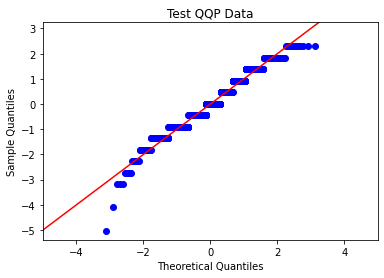

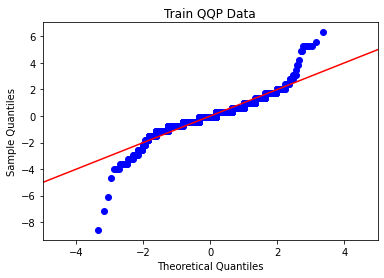

In [8]:
RunQQplot (df_X_test_No_ID, y_hat_test, "Test QQP Data")
RunQQplot (df_X_train_No_ID, y_hat_train, "Train QQP Data")

Big Tails, hope to improve as I incorporate more freatures, however Durbin Watson under 2 so should be ok

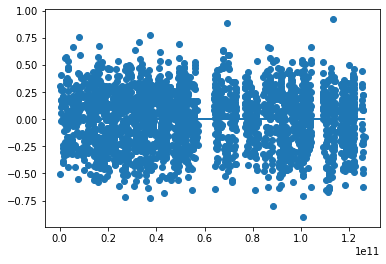

In [9]:
plt.scatter(Model1.predict(df_X_train), Model1.resid)
plt.plot(Model1.predict(df_X_train), [0 for i in range(len(df_X_train))]);

Rediduals seem to be equally distributed against dependents, Homescedicity should be ok

## Deep Dive On Residuals

This section used to do deep dive on residuals by parcel ID

Text(0.5, 1.0, 'Residuals PDF')

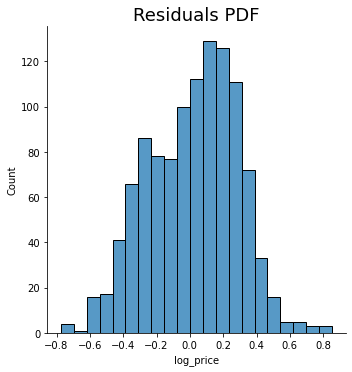

In [10]:
#View residualst, looks like model is currently under and over predicting
sns.displot(df_y_test-y_hat_test)
plt.title("Residuals PDF", size=18)

Create Dataframe of Residuals to Review For Additional Model Improvement, Looks like current model is over predicting a little more aggresively than under predicting

In [11]:
df_TestResiduals = CheckResiduals (y_hat_test, df_y_test, df_X_test)
CheckForResiduals_No_Dummies = df_TestResiduals.merge(df_Target_Homes_For_xref, on="id")
CheckForResiduals_with_Dummies = df_TestResiduals.merge(data_Model1, on="id")

In [12]:
plotHousesWithBigErrors = CheckForResiduals_No_Dummies.sort_values(by="PercentDiff", ascending=False).head(50)
plotHousesWithBigErrors.head(5)

,id,Actual,Predictions,Residual,Residual_abs,PercentDiff,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,AgeOfHome,ZipFirst3_int,salesyear,...,view_1,view_2,view_3,view_4,condition_3,condition_4,condition_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,sls_mnth_2,sls_mnth_3,sls_mnth_4,sls_mnth_5,sls_mnth_6,sls_mnth_7,sls_mnth_8,sls_mnth_9,sls_mnth_10,sls_mnth_11,sls_mnth_12,If_renovated_1
0,1180000885,340500.0,738185.805415,-397685.805415,397685.805415,116.794657,10/30/2014,340500.0,3,2.50,3070,5871,3.0,2510,560.0,1928,0.0,98178,47.5007,-122.223,2220,4000,92,981,2014,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,2612000390,269950.0,584881.998733,-314931.998733,314931.998733,116.663085,6/15/2014,269950.0,3,2.50,1890,4838,2.0,1730,160.0,2002,0.0,98168,47.4802,-122.279,1910,7409,18,981,2014,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,2114700040,260000.0,534027.376662,-274027.376662,274027.376662,105.395145,4/14/2015,260000.0,3,2.75,1730,4131,2.0,1480,250.0,1975,0.0,98106,47.5327,-122.346,1570,4120,45,981,2015,...,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,3023049236,350000.0,702293.826821,-352293.826821,352293.826821,100.655379,9/16/2014,350000.0,3,2.75,3070,5280,2.0,2360,710.0,1950,1986.0,98166,47.4486,-122.353,2570,18983,70,981,2014,...,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
4,4136880140,254500.0,490955.939162,-236455.939162,236455.939162,92.909996,5/22/2014,254500.0,4,2.75,2570,7264,2.0,1720,850.0,1998,0.0,98092,47.2580,-122.208,2420,7911,22,980,2014,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


SaveModel For Use In Analysis Files

In [13]:
with open('./data/PickleFiles/regression_Initial_Model_sk.pickle', 'wb') as f:
    pickle.dump(sk_model1, f)

# <u><font color='red'>Model 2</font></u>

## Run Model

In [14]:
# Load Data From Pickel
with open('./data/PickleFiles/regression_Data_Second_Model.pickle', 'rb') as file:
    data_Model2 = pickle.load(file)

In [15]:
# For SKlearn Model
model2_features_w_id = list(data_Model2.columns).copy()
model2_features_w_id = [e for e in model2_features_w_id if e not in (meta_data_To_Remove_From_SKmodel)]

# For StatsModel Model
model2_features_wo_id = list(data_Model2.columns).copy()
model2_features_wo_id = [e for e in model2_features_wo_id if e not in (meta_data_To_Remove_From_Statsmodel)]


In [16]:
# 0_X_train, 1_X_test, 2_y_train, 3_y_test, 4_X_train_No_ID, 5_X_test_No_ID)
listOfTrainSplit_Dfs = CreateTrainTestSplit(data_Model2, model2_features_w_id)

df_X_train = listOfTrainSplit_Dfs[0]
df_X_test = listOfTrainSplit_Dfs[1]
df_y_train = listOfTrainSplit_Dfs[2]
df_y_test = listOfTrainSplit_Dfs[3]
df_X_train_No_ID = listOfTrainSplit_Dfs[4]
df_X_test_No_ID = listOfTrainSplit_Dfs[5]

sk_model2 = CreateModel_SK(df_X_train_No_ID, df_y_train)
df_Model2_Results_SK, y_hat_train, y_hat_test = RunPrediction(sk_model2, df_X_train_No_ID, df_X_test_No_ID, df_y_train, df_y_test)


# df_Model2_Results_SK, y_hat_train, y_hat_test = CreateModel_SK(df_X_train_No_ID, df_X_test_No_ID, df_y_train, df_y_test)

In [17]:
model2_features_w_id

['id',
 'Sch_d_Top15',
 'Sch_d_Top30',
 'Sch_d_Top60',
 'Under10',
 'Over20',
 'sqft_lot',
 'sqft_basement',
 'sqft_above',
 'view_1',
 'view_2',
 'view_3',
 'view_4',
 'condition_4',
 'condition_5',
 'grade_6',
 'grade_8',
 'grade_9',
 'grade_10',
 'sls_mnth_2',
 'sls_mnth_3',
 'sls_mnth_4',
 'sls_mnth_5',
 'sls_mnth_6',
 'sls_mnth_7',
 'sls_mnth_8',
 'sls_mnth_9',
 'sls_mnth_10',
 'sls_mnth_11',
 'sls_mnth_12',
 'If_renovated_1']

In [18]:
df_Model2_Results_SK

,Measure,Value
0,train_R2,0.684
1,test_R2,0.678
2,train_mse,0.0363533
3,test_mse,0.0365513
4,intercept,12.5296
5,Sch_d_Top15,0.359512
6,Sch_d_Top30,0.357542
7,Sch_d_Top60,-0.070847
8,Under10,0.160892
9,Over20,-0.703032


In [19]:
Model2, residuals2 = CreateModel_stats (df_y_train ,df_X_train, model2_features_wo_id)
Model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     183.2
Date:                Wed, 25 Nov 2020   Prob (F-statistic):               0.00
Time:                        06:11:01   Log-Likelihood:                 611.71
No. Observations:                2567   AIC:                            -1161.
Df Residuals:                    2536   BIC:                            -980.0
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             12.5296      0.030    423.032      0.000      12.472      12.588
Sch_d_Top15        0.3595      0.012     29.688      0.000       0.336       0.383
Sch_d_Top30        0.3575      0.013     26.582      0.000       0.331       0.384
Sch_d_Top60       -0.0708      0.020     -3.506      0.000      -0.110      -0.031
Under10            0.1609      0.031      5.178      0.000       0.100       0.222
Over20            -0.7030      0.055    -12.895      0.000      -0.810      -0.596
sqft_lot          -0.1028      0.017     -5.980      0.000      -0.137      -0.069
sqft_basement      0.1057      0.028      3.837      0.000       0.052       0.160
sqft_above         0.5845      0.035     16.781      0.000       0.516       0.653
view_1             0.0867      0.025      3.475      0.001       0.038       0.136
view_2             0.0942      0.016      5.891      0.000       0.063       0.126
view_3             0.0935      0.024      3.872      0.000       0.046       0.141
view_4             0.2644      0.052      5.091      0.000       0.163       0.366
condition_4        0.0880      0.008     10.382      0.000       0.071       0.105
condition_5        0.1407      0.013     11.042      0.000       0.116       0.166
grade_6           -0.1576      0.016     -9.685      0.000      -0.190      -0.126
grade_8            0.1543      0.010     15.771      0.000       0.135       0.174
grade_9            0.2617      0.021     12.414      0.000       0.220       0.303
grade_10           0.2522      0.047      5.311      0.000       0.159       0.345
sls_mnth_2         0.0128      0.026      0.499      0.618      -0.038       0.063
sls_mnth_3         0.0678      0.024      2.822      0.005       0.021       0.115
sls_mnth_4         0.0637      0.023      2.730      0.006       0.018       0.109
sls_mnth_5         0.0305      0.023      1.321      0.187      -0.015       0.076
sls_mnth_6        -0.0072      0.023     -0.307      0.759      -0.053       0.039
sls_mnth_7         0.0047      0.024      0.198      0.843      -0.042       0.051
sls_mnth_8         0.0036      0.024      0.153      0.878      -0.043       0.050
sls_mnth_9         0.0040      0.024      0.168      0.866      -0.043       0.051
sls_mnth_10       -0.0018      0.024     -0.074      0.941      -0.048       0.045
sls_mnth_11       -0.0104      0.025     -0.411      0.681      -0.060       0.039
sls_mnth_12       -0.0073      0.025     -0.299      0.765      -0.055       0.041
If_renovated_1     0.1067      0.022      4.823      0.000       0.063       0.150
==============================================================================
Omnibus:                       47.631   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.239
Skew:                   

## Checking Model 2 For Residual Normality and Homoscedasticity

<ipython-input-2-b3f0994db059>:89: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-2-b3f0994db059>:89: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


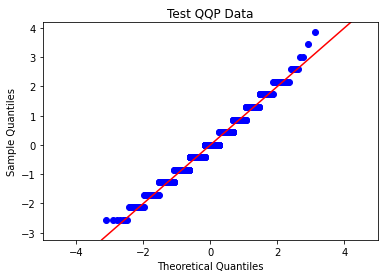

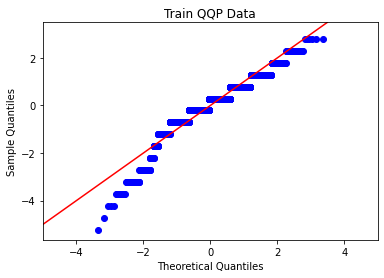

In [20]:
RunQQplot (df_X_test_No_ID, y_hat_test, "Test QQP Data")
RunQQplot (df_X_train_No_ID, y_hat_train, "Train QQP Data")

Big Tails on Train Model, hope to improve as I incorporate more freatures, however Durbin Watson under 2 so should be ok

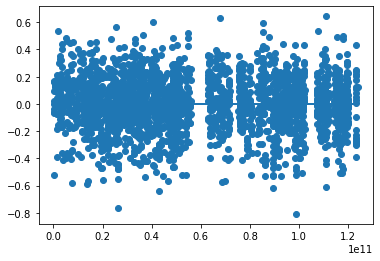

In [21]:
plt.scatter(Model2.predict(df_X_train), Model2.resid)
plt.plot(Model2.predict(df_X_train), [0 for i in range(len(df_X_train))]);

In reviewing for homoscedicity, does not seem to have pattern or cone shape

## Deep Dive On Residuals

Text(0.5, 1.0, 'Residuals PDF')

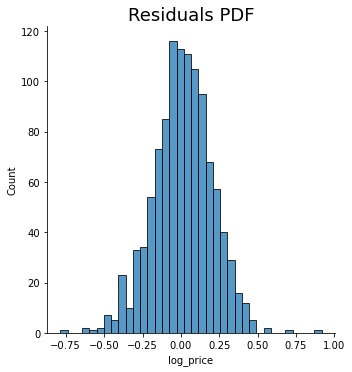

In [22]:
sns.displot(df_y_test-y_hat_test)
plt.title("Residuals PDF", size=18)

Create Dataframe of Residuals to Review For Additional Model Improvement, Looks like current model is over predicting a little more aggresively than under predicting

In [23]:
df_TestResiduals = CheckResiduals (y_hat_test, df_y_test, df_X_test)
CheckForResiduals_No_Dummies = df_TestResiduals.merge(df_Target_Homes_For_xref, on="id")
CheckForResiduals_with_Dummies = df_TestResiduals.merge(data_Model2, on="id")

In [24]:
plotHousesWithBigErrors = CheckForResiduals_No_Dummies.sort_values(by="PercentDiff", ascending=False).head(5)
plotHousesWithBigErrors.head(5)

,id,Actual,Predictions,Residual,Residual_abs,PercentDiff,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,AgeOfHome,ZipFirst3_int,salesyear,...,view_1,view_2,view_3,view_4,condition_3,condition_4,condition_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,sls_mnth_2,sls_mnth_3,sls_mnth_4,sls_mnth_5,sls_mnth_6,sls_mnth_7,sls_mnth_8,sls_mnth_9,sls_mnth_10,sls_mnth_11,sls_mnth_12,If_renovated_1
0,2114700040,260000.0,569932.793195,-309932.793195,309932.793195,119.204920,4/14/2015,260000.0,3,2.75,1730,4131,2.0,1480,250.0,1975,0.0,98106,47.5327,-122.346,1570,4120,45,981,2015,...,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,393000311,286300.0,542714.563452,-256414.563452,256414.563452,89.561496,2/25/2015,286300.0,3,2.75,2000,6405,1.0,1260,740.0,1964,0.0,98178,47.5066,-122.259,2130,6510,56,981,2015,...,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,8101900100,310000.0,562757.094517,-252757.094517,252757.094517,81.534547,3/28/2015,310000.0,3,1.00,1510,6000,1.0,1170,340.0,1953,0.0,98118,47.5168,-122.285,1125,6000,67,981,2015,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,3904100220,276000.0,481984.758789,-205984.758789,205984.758789,74.632159,12/9/2014,276000.0,2,2.00,1480,6075,1.0,740,740.0,1919,0.0,98118,47.5317,-122.276,1230,6053,101,981,2014,...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2112700280,295000.0,494723.300457,-199723.300457,199723.300457,67.702814,8/11/2014,295000.0,3,1.75,1440,4000,1.0,1050,390.0,1979,0.0,98106,47.5329,-122.354,1560,4000,41,981,2014,...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [25]:
with open('./data/PickleFiles/regression_Second_Model_sk.pickle', 'wb') as f:
    pickle.dump(sk_model2, f)

# <u><font color='red'>Model 3</font></u>

## Run Model

In [26]:
with open('./data/PickleFiles/regression_Data_Third_Model.pickle', 'rb') as file:
    data_Model3 = pickle.load(file)

In [27]:
# For SKlearn Model
model3_features_w_id = list(data_Model3.columns).copy()
model3_features_w_id = [e for e in model3_features_w_id if e not in (meta_data_To_Remove_From_SKmodel)]

# For StatsModel Model
model3_features_wo_id = list(data_Model3.columns).copy()
model3_features_wo_id = [e for e in model3_features_wo_id if e not in (meta_data_To_Remove_From_Statsmodel)]

In [28]:
# 0_X_train, 1_X_test, 2_y_train, 3_y_test, 4_X_train_No_ID, 5_X_test_No_ID)
listOfTrainSplit_Dfs = CreateTrainTestSplit(data_Model3, model3_features_w_id)

df_X_train = listOfTrainSplit_Dfs[0]
df_X_test = listOfTrainSplit_Dfs[1]
df_y_train = listOfTrainSplit_Dfs[2]
df_y_test = listOfTrainSplit_Dfs[3]
df_X_train_No_ID = listOfTrainSplit_Dfs[4]
df_X_test_No_ID = listOfTrainSplit_Dfs[5]

sk_model3 = CreateModel_SK(df_X_train_No_ID, df_y_train)
df_Model3_Results_SK, y_hat_train, y_hat_test = RunPrediction(sk_model3, df_X_train_No_ID, df_X_test_No_ID, df_y_train, df_y_test)

In [29]:
df_Model3_Results_SK

,Measure,Value
0,train_R2,0.830
1,test_R2,0.800
2,train_mse,0.0207198
3,test_mse,0.023869
4,intercept,12.4181
5,AssesorAppraisals_x,1.19366
6,Sch_d_Top15,0.224482
7,Sch_d_Top30,0.197072
8,Sch_d_Top60,-0.0203361
9,Under10,0.132568


In [30]:
df_y_train.shape

(1288,)

In [31]:
Model3, residuals3 = CreateModel_stats (df_y_train ,df_X_train, model3_features_wo_id)
Model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     197.9
Date:                Wed, 25 Nov 2020   Prob (F-statistic):               0.00
Time:                        06:11:02   Log-Likelihood:                 668.98
No. Observations:                1288   AIC:                            -1274.
Df Residuals:                    1256   BIC:                            -1109.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  12.4181      0.029    422.739      0.000      12.360      12.476
AssesorAppraisals_x     1.1937      0.044     26.950      0.000       1.107       1.281
Sch_d_Top15             0.2245      0.013     17.086      0.000       0.199       0.250
Sch_d_Top30             0.1971      0.015     12.770      0.000       0.167       0.227
Sch_d_Top60            -0.0203      0.020     -1.025      0.305      -0.059       0.019
Under10                 0.1326      0.035      3.796      0.000       0.064       0.201
Over20                 -0.3784      0.052     -7.340      0.000      -0.480      -0.277
view_1                  0.0594      0.026      2.275      0.023       0.008       0.111
view_2                  0.0562      0.018      3.118      0.002       0.021       0.092
view_3                  0.0183      0.025      0.743      0.458      -0.030       0.067
view_4                  0.1064      0.057      1.865      0.062      -0.006       0.218
condition_4             0.0389      0.009      4.147      0.000       0.021       0.057
condition_5             0.1164      0.014      8.295      0.000       0.089       0.144
grade_6                -0.0749      0.020     -3.755      0.000      -0.114      -0.036
grade_8                 0.0605      0.011      5.484      0.000       0.039       0.082
grade_9                 0.0363      0.024      1.532      0.126      -0.010       0.083
grade_10                0.0930      0.049      1.916      0.056      -0.002       0.188
sls_mnth_2              0.0120      0.026      0.454      0.650      -0.040       0.064
sls_mnth_3              0.0530      0.024      2.202      0.028       0.006       0.100
sls_mnth_4              0.0755      0.023      3.249      0.001       0.030       0.121
sls_mnth_5              0.0738      0.023      3.206      0.001       0.029       0.119
sls_mnth_6              0.0898      0.023      3.852      0.000       0.044       0.135
sls_mnth_7              0.0730      0.024      3.061      0.002       0.026       0.120
sls_mnth_8              0.0779      0.024      3.266      0.001       0.031       0.125
sls_mnth_9              0.0564      0.024      2.309      0.021       0.008       0.104
sls_mnth_10             0.0698      0.024      2.925      0.004       0.023       0.117
sls_mnth_11             0.0695      0.025      2.800      0.005       0.021       0.118
sls_mnth_12             0.0667      0.025      2.681      0.007       0.018       0.116
If_renovated_1          0.0214      0.024      0.895      0.371      -0.025       0.068
sqft_lot               -0.0401      0.019     -2.062      0.039      -0.078      -0.002
sqft_basement           0.1200      0.029      4.077      0.000       0.062       0.178
sqft_above              0.3104      0.041      7.569      0.000       0.230       0.391
===

## Checking Model 3 For Residual Normality and Homoscedasticity

<ipython-input-2-b3f0994db059>:89: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-2-b3f0994db059>:89: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


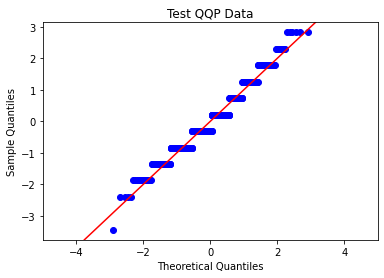

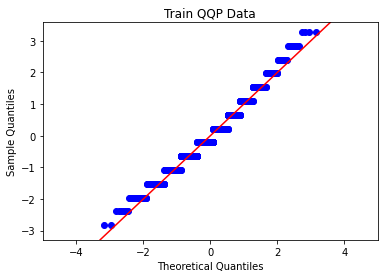

In [32]:
RunQQplot (df_X_test_No_ID, y_hat_test, "Test QQP Data")
RunQQplot (df_X_train_No_ID, y_hat_train, "Train QQP Data")

Looking at QQ plot, Normality of residual seems to have been improved by adding additional features and removing additional 
outliers

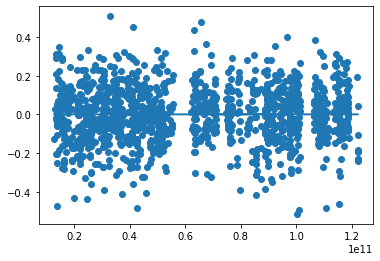

In [33]:
plt.scatter(Model3.predict(df_X_train), Model3.resid)
plt.plot(Model3.predict(df_X_train), [0 for i in range(len(df_X_train))]);

Per above homoscedicity does not seem to be present

## Backword Elimination

In [34]:
#Backward Elimination
df_y_train ,df_X_train, model3_features_wo_id

# y = df['msrp']
y = df_y_train
cols = model3_features_wo_id
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = df_X_train[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)
    
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
# print(selected_features_BE)
df_final_Features = p.to_frame("Pvalue")
df_final_Features.index.name = 'Features'
df_final_Features

,Pvalue
Features,
AssesorAppraisals_x,1.457786e-152
Sch_d_Top15,2.249368e-66
Sch_d_Top30,7.722127e-45
Under10,5.172147e-06
Over20,1.479170e-12
view_1,2.153971e-02
view_2,2.670138e-03
view_4,4.569921e-02
condition_4,1.654933e-04


In [35]:
df_final_Features.reset_index()

,Features,Pvalue
0,AssesorAppraisals_x,1.457786e-152
1,Sch_d_Top15,2.249368e-66
2,Sch_d_Top30,7.722127e-45
3,Under10,5.172147e-06
4,Over20,1.479170e-12
5,view_1,2.153971e-02
6,view_2,2.670138e-03
7,view_4,4.569921e-02
8,condition_4,1.654933e-04
9,condition_5,5.606777e-16


In [36]:
df_final_Features = df_final_Features.reset_index()
df_final_Features = df_final_Features.sort_values(by="Pvalue")
df_final_Features

,Features,Pvalue
0,AssesorAppraisals_x,1.457786e-152
1,Sch_d_Top15,2.249368e-66
2,Sch_d_Top30,7.722127e-45
23,sqft_above,1.328538e-19
9,condition_5,5.606777e-16
4,Over20,1.479170e-12
11,grade_8,8.782224e-07
15,sls_mnth_6,3.191972e-06
3,Under10,5.172147e-06
22,sqft_basement,3.566621e-05


## Deep Dive On Residuals

Text(0.5, 1.0, 'Residuals PDF')

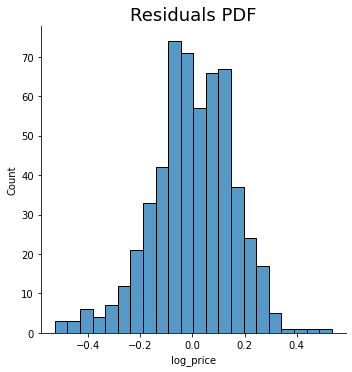

In [37]:
sns.displot(df_y_test-y_hat_test)
plt.title("Residuals PDF", size=18)

Create Dataframe of Residuals to Review For Additional Model Improvement, Looks like current model is over predicting a little more aggresively than under predicting

In [38]:
df_TestResiduals = CheckResiduals (y_hat_test, df_y_test, df_X_test)
CheckForResiduals_No_Dummies = df_TestResiduals.merge(df_Target_Homes_For_xref, on="id")
CheckForResiduals_with_Dummies = df_TestResiduals.merge(data_Model3, on="id")

In [39]:
plotHousesWithBigErrors = CheckForResiduals_No_Dummies.sort_values(by="PercentDiff", ascending=True).head(50)
plotHousesWithBigErrors.head(5)

,id,Actual,Predictions,Residual,Residual_abs,PercentDiff,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,AgeOfHome,ZipFirst3_int,salesyear,...,view_1,view_2,view_3,view_4,condition_3,condition_4,condition_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,sls_mnth_2,sls_mnth_3,sls_mnth_4,sls_mnth_5,sls_mnth_6,sls_mnth_7,sls_mnth_8,sls_mnth_9,sls_mnth_10,sls_mnth_11,sls_mnth_12,If_renovated_1
552,9284801435,471000.0,470731.637532,268.362468,268.362468,0.056977,12/3/2014,471000.0,4,1.75,1760,5750,1.0,1070,690.0,1962,0.0,98126,47.5521,-122.373,1860,5750,58,981,2014,...,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
551,7577700061,532000.0,531615.469756,384.530244,384.530244,0.072280,4/16/2015,532000.0,3,1.00,2360,5012,1.0,1560,800.0,1964,0.0,98116,47.5705,-122.384,1690,4800,56,981,2015,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
550,8731800300,299000.0,299289.758841,-289.758841,289.758841,0.096909,7/23/2014,299000.0,3,2.25,1940,9100,1.0,1630,310.0,1966,0.0,98023,47.3133,-122.364,2080,9100,54,980,2014,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
549,9285800275,835000.0,835848.917213,-848.917213,848.917213,0.101667,8/14/2014,835000.0,3,2.25,2520,6690,2.0,1700,820.0,1944,1990.0,98126,47.5705,-122.381,1990,5792,76,981,2014,...,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
548,4058802335,326000.0,326366.389843,-366.389843,366.389843,0.112390,11/25/2014,326000.0,4,1.75,2290,7380,1.0,1390,900.0,1963,0.0,98178,47.5034,-122.245,1170,7381,57,981,2014,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [40]:
with open('./data/PickleFiles/regression_Third_Model_sk.pickle', 'wb') as f:
    pickle.dump(sk_model3, f)

# <u><font color='blue'>3 Models Side By Side</font></u>

In [41]:
listofModels = []
listofModels.append(df_Model1_Results_SK)
listofModels.append(df_Model2_Results_SK)
listofModels.append(df_Model3_Results_SK)
display_side_by_side_withNames(listofModels, names=["Model1", "Model2", "Model3"])

Model1,Model2,Model3
,Measure,Value
0,train_R2,0.401
1,test_R2,0.372
2,train_mse,0.0689523
3,test_mse,0.0712373
4,intercept,12.7574
5,waterfront_1,0.191622
6,view_1,0.125222
7,view_2,0.0629582
8,view_3,0.0328921


Overall models look good.  MSE goes down on all models, adjr2 goes up.  Only negative is the durbin watson
going up slightly on model 3.  Model 4 below is final model 

In [42]:
from statsmodels.stats.stattools import durbin_watson

#perform Durbin-Watson test
resid1 = durbin_watson(residuals1)
resid2 = durbin_watson(residuals2)
resid3 = durbin_watson(residuals3)

df = pd.DataFrame([resid1, resid2,resid3], index =['1', '2', '3'], 
                                              columns =['Durbin-Watson']) 
df 

,Durbin-Watson
1,1.970781
2,1.986095
3,2.025427


Final distribution of Home Prices

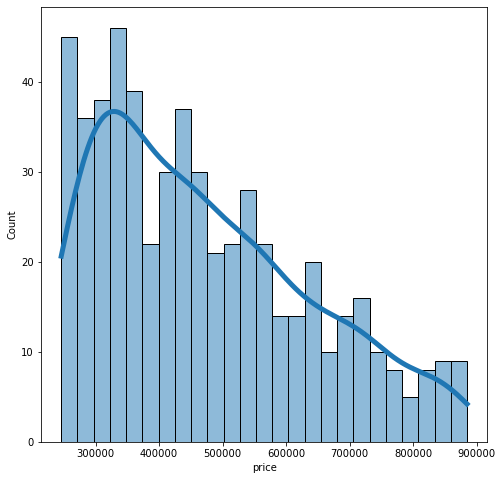

In [43]:
#distribution of Target/ dependent
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
sns.histplot(x= "price",
             data=CheckForResiduals_No_Dummies,
             bins=25,
             kde=True,
             line_kws={"linewidth":5}, ax=ax,)
plt.show()

In [44]:
Model4, residuals4 = CreateModel_stats (df_y_train ,df_X_train, selected_features_BE)
Model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     254.4
Date:                Wed, 25 Nov 2020   Prob (F-statistic):               0.00
Time:                        06:11:04   Log-Likelihood:                 663.58
No. Observations:                1288   AIC:                            -1277.
Df Residuals:                    1263   BIC:                            -1148.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  12.3818      0.021    576.995      0.000      12.340      12.424
AssesorAppraisals_x     1.2368      0.041     30.371      0.000       1.157       1.317
Sch_d_Top15             0.2257      0.012     18.274      0.000       0.202       0.250
Sch_d_Top30             0.2060      0.014     14.620      0.000       0.178       0.234
Under10                 0.1524      0.033      4.577      0.000       0.087       0.218
Over20                 -0.3516      0.049     -7.149      0.000      -0.448      -0.255
view_1                  0.0598      0.026      2.301      0.022       0.009       0.111
view_2                  0.0538      0.018      3.009      0.003       0.019       0.089
view_4                  0.1124      0.056      2.000      0.046       0.002       0.223
condition_4             0.0350      0.009      3.778      0.000       0.017       0.053
condition_5             0.1143      0.014      8.205      0.000       0.087       0.142
grade_6                -0.0682      0.020     -3.442      0.001      -0.107      -0.029
grade_8                 0.0483      0.010      4.942      0.000       0.029       0.067
sls_mnth_3              0.0449      0.019      2.326      0.020       0.007       0.083
sls_mnth_4              0.0665      0.018      3.647      0.000       0.031       0.102
sls_mnth_5              0.0690      0.018      3.843      0.000       0.034       0.104
sls_mnth_6              0.0859      0.018      4.679      0.000       0.050       0.122
sls_mnth_7              0.0672      0.019      3.529      0.000       0.030       0.105
sls_mnth_8              0.0724      0.019      3.815      0.000       0.035       0.110
sls_mnth_9              0.0508      0.020      2.573      0.010       0.012       0.090
sls_mnth_10             0.0649      0.019      3.413      0.001       0.028       0.102
sls_mnth_11             0.0658      0.020      3.261      0.001       0.026       0.105
sls_mnth_12             0.0620      0.020      3.053      0.002       0.022       0.102
sqft_basement           0.1204      0.029      4.149      0.000       0.063       0.177
sqft_above              0.3468      0.038      9.209      0.000       0.273       0.421
==============================================================================
Omnibus:                       15.828   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.376
Skew:                          -0.142   Prob(JB):                     2.28e-05
Kurtosis:                       3.563   Cond. No.                         20.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Final Model above adj r2 = .83, durbin under 2.5, MSE reduced through progression of project

# EXTRA CREDIT - Exploring Model 2 Ability to Predict Assesor Appraisals 

In [45]:
# Load Data From Pickel
with open('./data/PickleFiles/df_Assesor_Appraisals_Check.pickle', 'rb') as file:
    df_Assesor_Appraisals_Check = pickle.load(file)

In [46]:
df = df_Assesor_Appraisals_Check

In [47]:
model_Extra_Credit_features_w_id = []
model_Extra_Credit_features_w_id = model2_features_w_id
# model_Extra_Credit_features_w_id.append("AppraisedTotal")

data_Model_Extra_Credit = df[data_Model2.columns]
# data_Model_Extra_Credit['AppraisedTotal'] = df['AppraisedTotal']
data_Model_Extra_Credit = data_Model_Extra_Credit.drop(columns=["log_price"])

#need to rename log_appraisal to log_price given "log_price hard coded into split fucntion"
data_Model_Extra_Credit['log_price'] = df['log_AppraisedTotal']

In [48]:
# 0_X_train, 1_X_test, 2_y_train, 3_y_test, 4_X_train_No_ID, 5_X_test_No_ID)
listOfTrainSplit_Dfs = CreateTrainTestSplit(data_Model_Extra_Credit, model_Extra_Credit_features_w_id)

df_X_train = listOfTrainSplit_Dfs[0]
df_X_test = listOfTrainSplit_Dfs[1]
df_y_train = listOfTrainSplit_Dfs[2]
df_y_test = listOfTrainSplit_Dfs[3]
df_X_train_No_ID = listOfTrainSplit_Dfs[4]
df_X_test_No_ID = listOfTrainSplit_Dfs[5]

In [49]:
sk_modelExtraCredit = CreateModel_SK(df_X_train_No_ID, df_y_train)
df_ModelEX_Results_SK, y_hat_train, y_hat_test = RunPrediction(sk_modelExtraCredit, df_X_train_No_ID, df_X_test_No_ID, df_y_train, df_y_test)


In [50]:
df_ModelEX_Results_SK

,Measure,Value
0,train_R2,0.737
1,test_R2,0.733
2,train_mse,0.0374024
3,test_mse,0.0386394
4,intercept,12.3369
5,Sch_d_Top15,0.313072
6,Sch_d_Top30,0.439637
7,Sch_d_Top60,-0.0320625
8,Under10,-0.153349
9,Over20,-0.845506


Based On Above model, our features contained in Model 2 explains 73 % of appraised price, biggest impact on model is sqrt _above at .84